In [19]:
import pandas as pd


In [20]:
# Function to read dataset and display basic information
def read_dataset(file_path):
    df = pd.read_csv(file_path)
    print('==============================================================================================================================')
    print(f'First few rows of the dataset: \n{df.head()}')
    print('==============================================================================================================================')
    print(df.info())
    print('==============================================================================================================================')
    print(f'Null values in the dataset: \n{df.isnull().sum()}')
    return df 

In [21]:
customer_df = read_dataset("Customer_Details.csv")


First few rows of the dataset: 
   Customer_ID Renewal_or_Non-renewal_Date  Zip_Code_Distance_From_Stadium  \
0       262688                    9/4/2013                       37.556232   
1       262688                    8/4/2014                       37.556232   
2       262719                   7/16/2013                       15.340993   
3       262719                    8/4/2014                       15.340993   
4       262782                   7/16/2013                       21.569895   

   Tenure_As_Season_Ticket_Member  
0                               1  
1                               2  
2                               1  
3                               2  
4                               8  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3781 entries, 0 to 3780
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Customer_ID                     3781 non-null   in

In [22]:
renewal_df = read_dataset("Renewal_Details.csv")


First few rows of the dataset: 
   Customer_ID                 Previous_Season  \
0       262688  2012 Basketball Season Tickets   
1       262719  2012 Basketball Season Tickets   
2       262782  2012 Basketball Season Tickets   
3       263277  2012 Basketball Season Tickets   
4       263410  2012 Basketball Season Tickets   

                   Renewal_Season  Renewal Renewal_or_Non-renewal_Date  \
0  2013 Basketball Season Tickets        1                    4-Sep-13   
1  2013 Basketball Season Tickets        1                   16-Jul-13   
2  2013 Basketball Season Tickets        1                   16-Jul-13   
3  2013 Basketball Season Tickets        1                   16-Jul-13   
4  2013 Basketball Season Tickets        1                   16-Jul-13   

   Average_Price_Paid_Per_Seat_Previous_Season  Total_Seats_Previous_Season  \
0                                       277.44                            2   
1                                       308.16                  

In [23]:
common_customer_ids = customer_df['Customer_ID'].isin(renewal_df['Customer_ID']).sum()
total_customer_ids = customer_df.shape[0]
print(f"Common Customer IDs: {common_customer_ids} out of {total_customer_ids}")
print(f"All customer IDs matched: {common_customer_ids == total_customer_ids}")

Common Customer IDs: 3781 out of 3781
All customer IDs matched: True


In [24]:
# Convert 'Renewal_or_Non-renewal_Date' columns to datetime
customer_df['Renewal_or_Non-renewal_Date'] = pd.to_datetime(customer_df['Renewal_or_Non-renewal_Date'], errors='coerce')
renewal_df['Renewal_or_Non-renewal_Date'] = pd.to_datetime(renewal_df['Renewal_or_Non-renewal_Date'], errors='coerce')

C:\Users\arjul\AppData\Local\Temp\ipykernel_28836\572240529.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  renewal_df['Renewal_or_Non-renewal_Date'] = pd.to_datetime(renewal_df['Renewal_or_Non-renewal_Date'], errors='coerce')


In [25]:
merged_data = pd.merge(customer_df, renewal_df, 
                       on=['Customer_ID', 'Renewal_or_Non-renewal_Date'], how='inner')

In [26]:
# Check for missing values
print("Missing values before handling:")
print(merged_data.isnull().sum())

Missing values before handling:
Customer_ID                                                                 0
Renewal_or_Non-renewal_Date                                                 2
Zip_Code_Distance_From_Stadium                                             80
Tenure_As_Season_Ticket_Member                                              0
Previous_Season                                                             0
Renewal_Season                                                              0
Renewal                                                                     0
Average_Price_Paid_Per_Seat_Previous_Season                                 0
Total_Seats_Previous_Season                                                 0
Team_Win_Pct_Previous_Season                                                0
Games_Attended_Previous_Season                                              0
Games_Missed_Previous_Season                                                0
Total_Games_Previous_Season     

In [27]:
# Drop rows where 'Renewal_or_Non-renewal_Date' is missing
merged_data = merged_data.dropna(subset=['Renewal_or_Non-renewal_Date'])

In [28]:
# Fill missing values in 'Zip_Code_Distance_From_Stadium' with the mean
merged_data['Zip_Code_Distance_From_Stadium'] = merged_data['Zip_Code_Distance_From_Stadium'].fillna(merged_data['Zip_Code_Distance_From_Stadium'].mean())


In [29]:
# Manual mapping for 'Section_Previous_Season'
section_mapping = {
    'Reserved_Seats': 0,
    'Platinum_Club': 1,
    'General_Admission': 2,
    'Club_Level': 3
}
merged_data['Section_Previous_Season'] = merged_data['Section_Previous_Season'].map(section_mapping)


In [30]:
# One-hot encoding for 'Previous_Season' and 'Renewal_Season'
df = pd.get_dummies(merged_data, columns=['Previous_Season', 'Renewal_Season'], drop_first=True)


In [31]:
# Feature Engineering
# 1. Time Since Last Renewal (in days)
df['Time_Since_Last_Renewal'] = (pd.to_datetime('2024-09-20') - df['Renewal_or_Non-renewal_Date']).dt.days

# 2. Game Attendance Ratio (Games Attended / Total Games)
df['Game_Attendance_Ratio'] = df['Games_Attended_Previous_Season'] / df['Total_Games_Previous_Season']

# 3. Engagement Score (Cumulative sum of engagement actions)
df['Engagement_Score'] = df['Phone_Calls_Made_to_Customer_Last_90_Days_Before_Renewal_Date'] + \
                         df['Live_Phone_Conversations_With_Customer_Last_90_Days_Before_Renewal_Date'] + \
                         df['Emails_Sent_Last_90_Days_Before_Renewal_Date']

df['Revenue_Per_Game'] = (df['Average_Price_Paid_Per_Seat_Previous_Season'] * df['Total_Seats_Previous_Season']) / df['Games_Attended_Previous_Season']
df['Total_Revenue'] = df['Revenue_Per_Game'] * df['Games_Attended_Previous_Season']

df['Games_Missed_Ratio'] = df['Games_Missed_Previous_Season'] / df['Total_Games_Previous_Season']

# Create Loyalty Feature (e.g., renewed multiple consecutive seasons)
df['Loyalty'] = (df['Tenure_As_Season_Ticket_Member'] > 3).astype(int)

# Create Churn Window (difference between last renewal date and current)
df['Churn_Window'] = (pd.to_datetime('2024-09-20') - df['Renewal_or_Non-renewal_Date']).dt.days

# Create Engagement Recency (days since last engagement)
df['Last_Engagement_Days'] = df[['Emails_Sent_Last_90_Days_Before_Renewal_Date',
                                'Phone_Calls_Made_to_Customer_Last_90_Days_Before_Renewal_Date']].max(axis=1)

In [32]:
print("DataFrame after feature engineering:")
print(df.head())
print(df.info())

DataFrame after feature engineering:
   Customer_ID Renewal_or_Non-renewal_Date  Zip_Code_Distance_From_Stadium  \
0       262688                  2013-09-04                       37.556232   
1       262688                  2014-08-04                       37.556232   
2       262719                  2013-07-16                       15.340993   
3       262719                  2014-08-04                       15.340993   
4       262782                  2013-07-16                       21.569895   

   Tenure_As_Season_Ticket_Member  Renewal  \
0                               1        1   
1                               2        1   
2                               1        1   
3                               2        1   
4                               8        1   

   Average_Price_Paid_Per_Seat_Previous_Season  Total_Seats_Previous_Season  \
0                                       277.44                            2   
1                                       269.28             

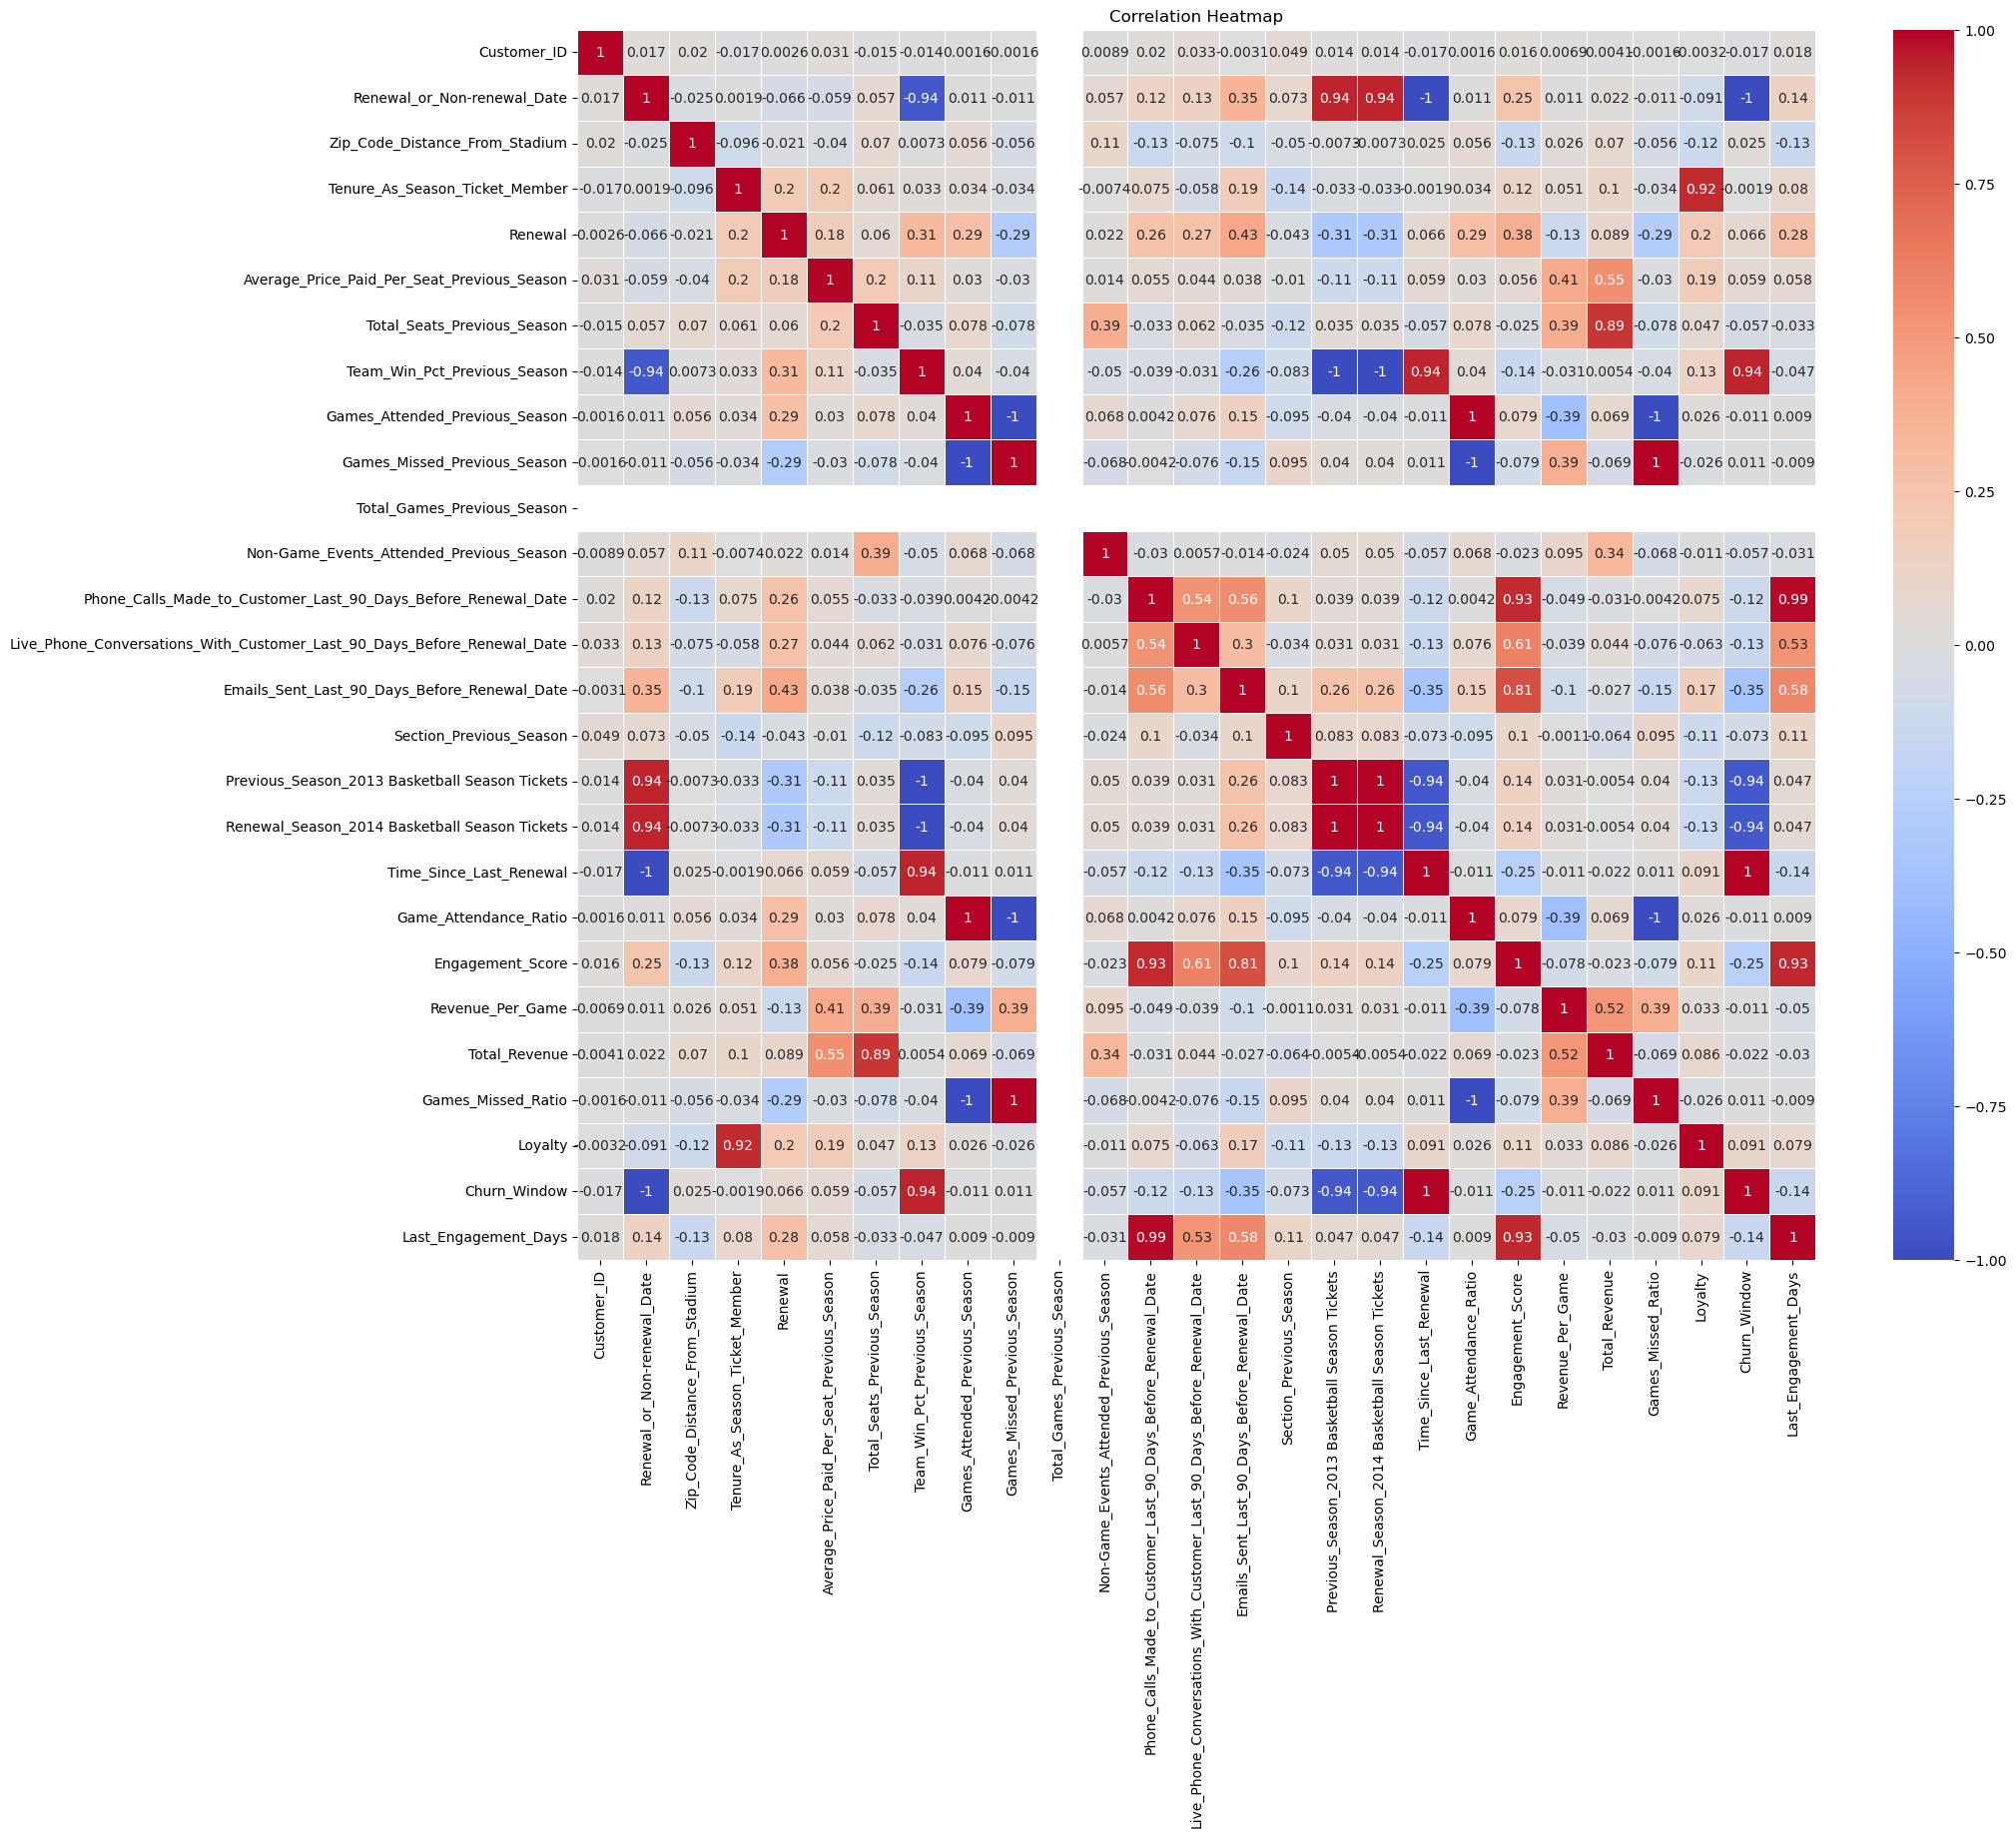

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df.corr()

# Generate a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")

# Save the heatmap to a file
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')

# Display the heatmap
plt.show()


## Splitting the dataset for training and testing

In [34]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Renewal'])

print(f"Training set size: {train_df.shape}")
print(f"Test set size: {test_df.shape}")


Training set size: (3023, 27)
Test set size: (756, 27)


# Churn Prediction

suggested coloumns

In [35]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Step 1: Define the features and target variable (Churn Prediction Model)
X = train_df[['Time_Since_Last_Renewal', 'Game_Attendance_Ratio', 'Engagement_Score', 
        'Revenue_Per_Game', 'Loyalty', 'Churn_Window', 'Last_Engagement_Days', 'Games_Missed_Ratio']]
y = train_df['Renewal']

# Step 2: Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Apply StandardScaler to standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Apply L2 Regularization (Ridge Regression) for Feature Selection
ridge_model = Ridge(alpha=1.0)  # You can tune the alpha parameter
ridge_model.fit(X_train_scaled, y_train)

# Get the coefficients from the Ridge model to understand feature importance
ridge_coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': ridge_model.coef_})
ridge_coefficients = ridge_coefficients.sort_values(by='Coefficient', ascending=False)

# Step 5: Check for Multicollinearity using VIF
# Apply VIF only on numeric data
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
vif_data = vif_data.sort_values(by="VIF", ascending=False)

# Step 6: Select columns with more lenient criteria for VIF and Ridge coefficients
# Allow more negative coefficients and increase the VIF threshold to 20
selected_features = ridge_coefficients[ridge_coefficients['Coefficient'] > -1]
vif_data_filtered = vif_data[vif_data["VIF"] < 20]  # More lenient VIF threshold

# Suggested columns are the ones that have both reasonable coefficients and acceptable VIF
suggested_columns = selected_features[selected_features['Feature'].isin(vif_data_filtered['Feature'])]

# Display the final suggested columns for churn prediction
print("Final Suggested Columns for Churn Prediction:")
print(suggested_columns)


Final Suggested Columns for Churn Prediction:
                Feature  Coefficient
2      Engagement_Score     0.342335
4               Loyalty     0.039237
3      Revenue_Per_Game     0.000312
6  Last_Engagement_Days    -0.223199


D:\installers\conda\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


multicolinearity check between the coloumns

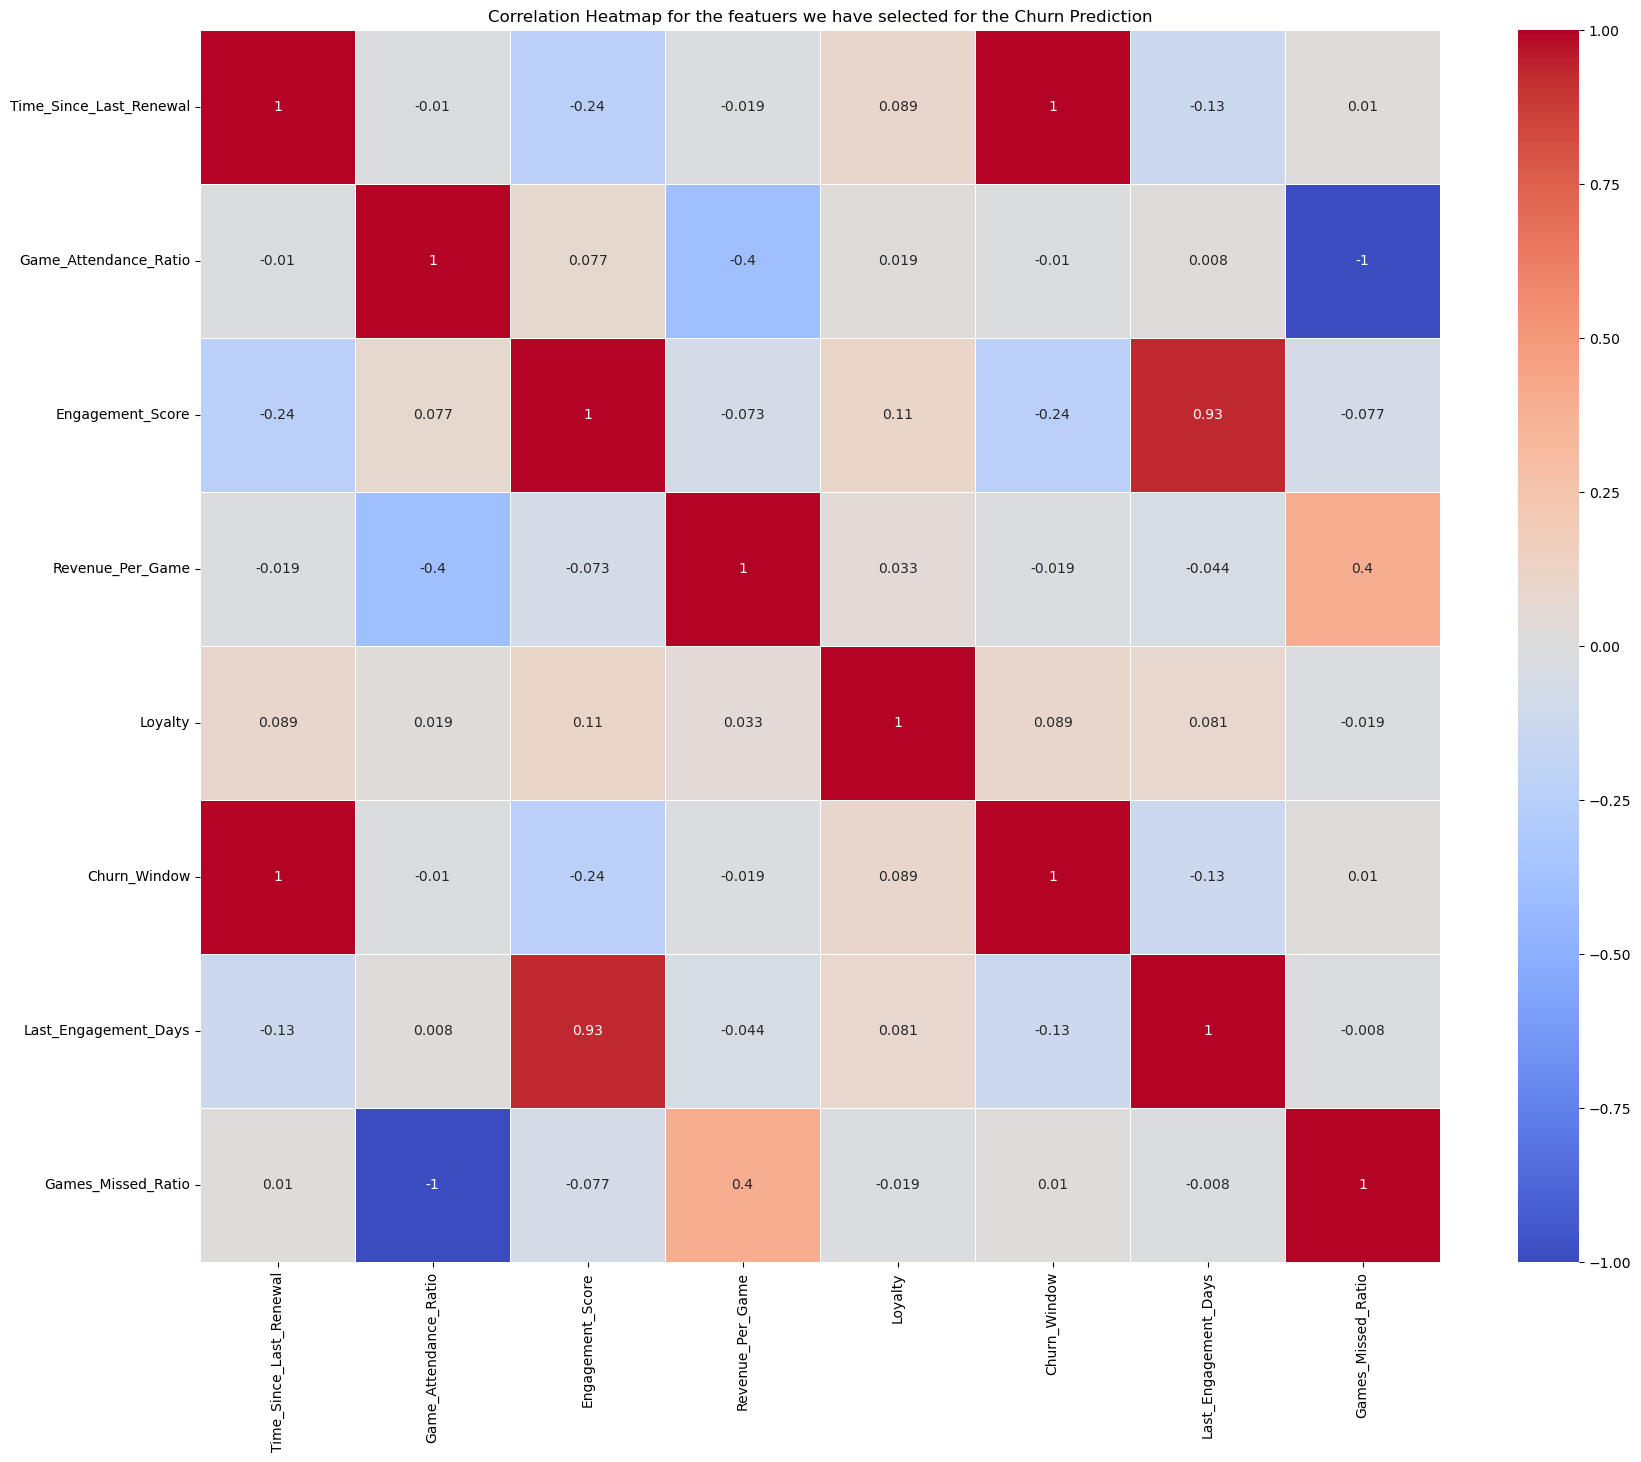

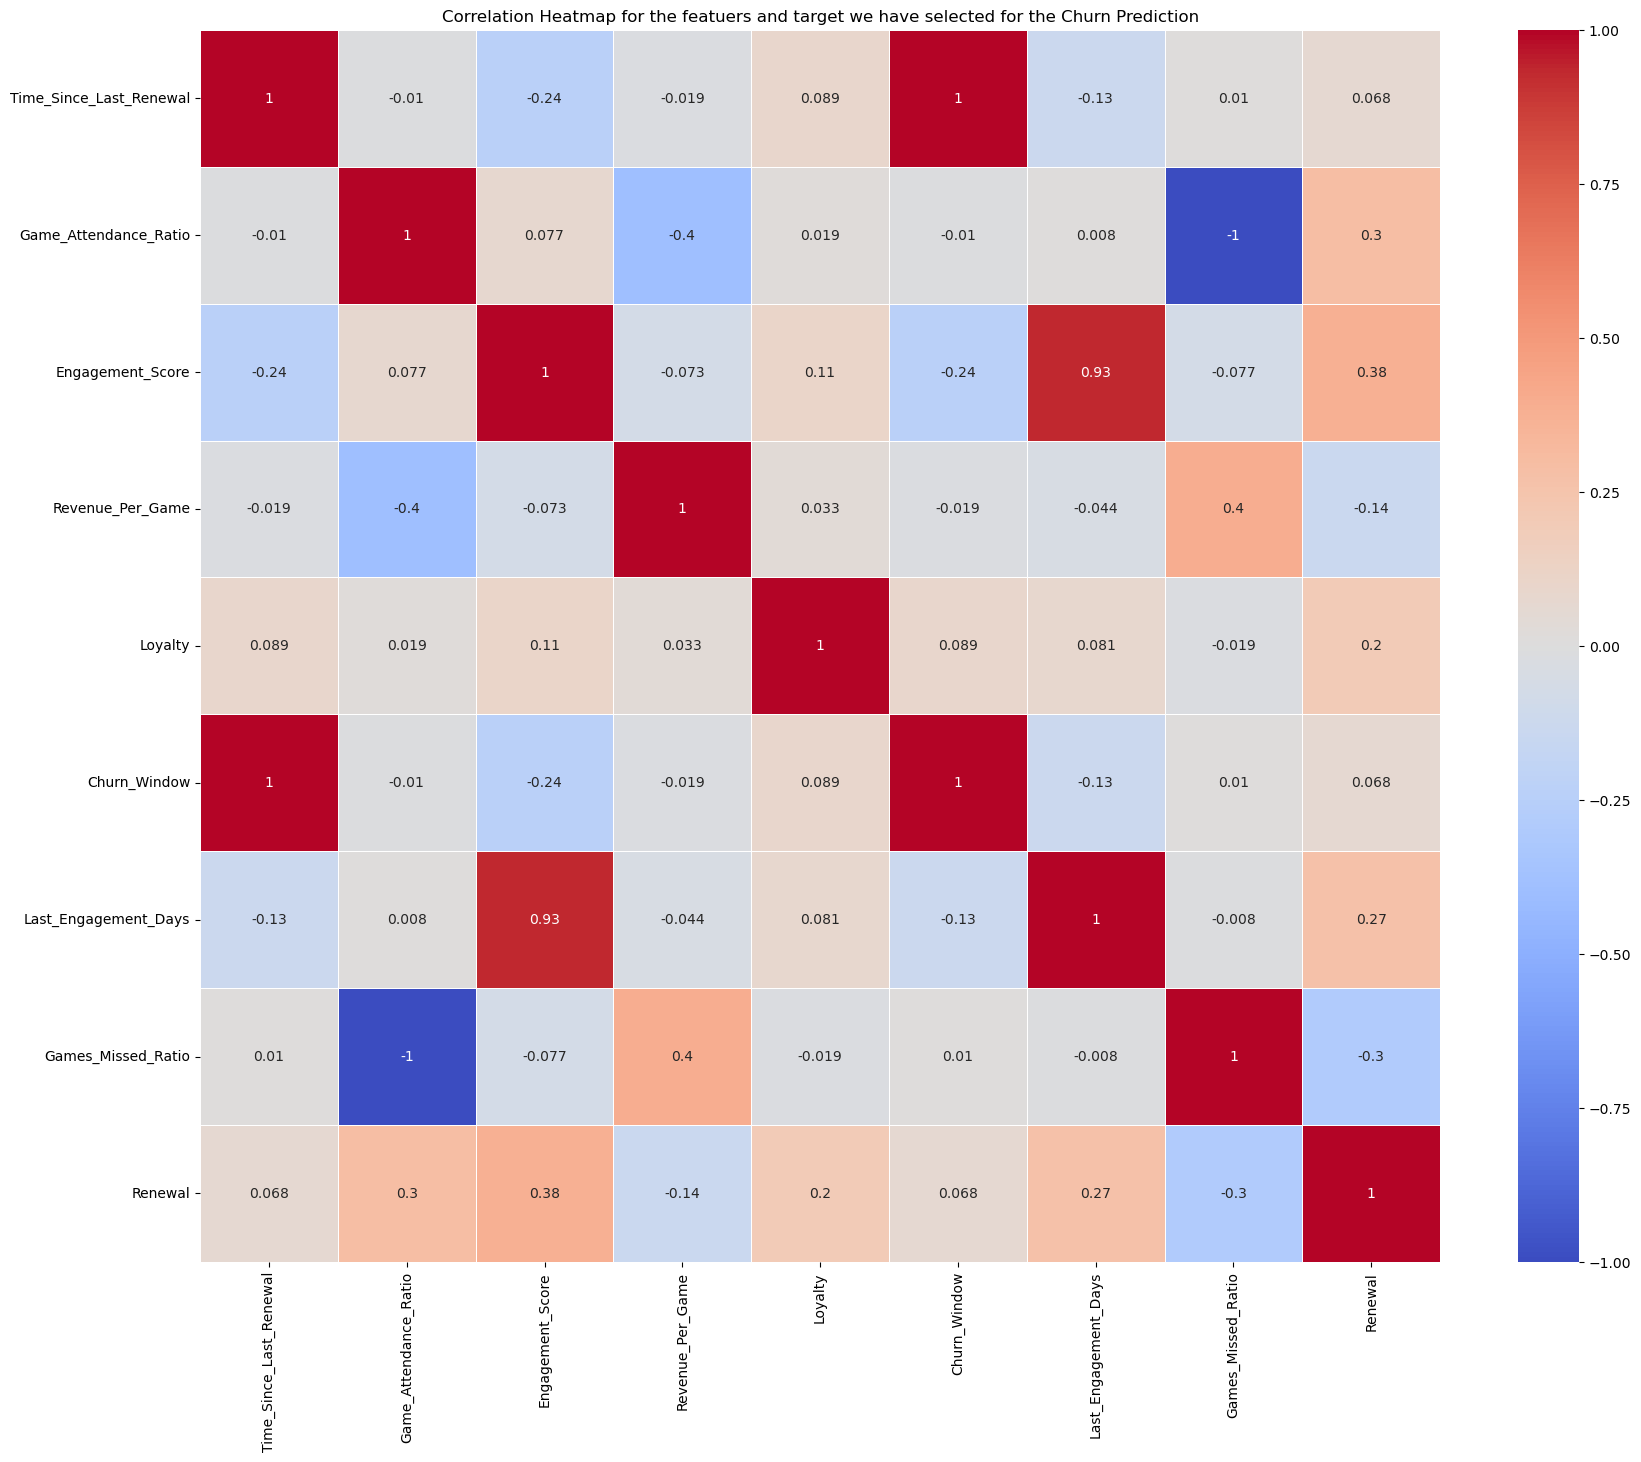

In [36]:
df1 = train_df[['Time_Since_Last_Renewal', 'Game_Attendance_Ratio', 'Engagement_Score', 
                       'Revenue_Per_Game', 'Loyalty', 'Churn_Window', 'Last_Engagement_Days', 'Games_Missed_Ratio','Renewal']]
X = train_df[['Time_Since_Last_Renewal', 'Game_Attendance_Ratio', 'Engagement_Score', 
                       'Revenue_Per_Game', 'Loyalty', 'Churn_Window', 'Last_Engagement_Days', 'Games_Missed_Ratio']]
y = train_df['Renewal']

corr_matrix1 = df1.corr()
corr_matrix = X.corr()

# Generate a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap for the featuers we have selected for the Churn Prediction")
plt.show()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix1, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap for the featuers and target we have selected for the Churn Prediction")
plt.show()


In [37]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, classification_report
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

# Step 1: Data Preprocessing Function
def preprocess_data_churn(dataset):
    X = dataset[['Engagement_Score', 'Loyalty', 'Revenue_Per_Game', 'Last_Engagement_Days']]
    y = dataset['Renewal']
    return X, y

# Step 2: Resampling (for balancing the dataset)
def apply_oversampling(X, y, method='SMOTEENN'):
    if method == 'SMOTEENN':
        oversampler = SMOTEENN(random_state=42)
    elif method == 'ADASYN':
        oversampler = ADASYN(random_state=42)
    else:
        return X, y  # No resampling
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    return X_resampled, y_resampled

# Step 3: Model Training and Evaluation Functions
def build_classification_pipeline(model, scaler=True):
    steps = []
    if scaler and not isinstance(model, (RandomForestClassifier, XGBClassifier)):
        steps.append(('scaler', StandardScaler()))
    steps.append(('classifier', model))
    return ImbPipeline(steps)

def tune_model(model, param_grid, X_train, y_train, use_random_search=False, cv=5):
    if use_random_search:
        search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=20, 
                                    cv=cv, scoring='roc_auc', n_jobs=4, verbose=2, random_state=42)
    else:
        search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=4, verbose=2)
    
    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    recall = recall_score(y_test, y_pred)
    
    print(f"Accuracy: {accuracy}")
    print(f"ROC AUC: {roc_auc}")
    print(f"Recall: {recall}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    
    return accuracy, roc_auc, recall

# Cross-Validation Function
def cross_validate_model(model, X, y, cv=5):
    roc_auc_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    return roc_auc_scores.mean(), roc_auc_scores.std()

# Step 4: Define Churn Prediction Algorithms and Hyperparameters
classification_algorithms = {
    "Logistic Regression": build_classification_pipeline(LogisticRegression(random_state=42, class_weight='balanced')),
    "Random Forest": build_classification_pipeline(RandomForestClassifier(random_state=42, class_weight='balanced'), scaler=False),
    "XGBoost": build_classification_pipeline(XGBClassifier(
        random_state=42, 
        tree_method='auto',       
        eval_metric='logloss'
    ), scaler=False)
}

param_grids = {
    "Logistic Regression": {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    },
    "Random Forest": {
        'classifier__n_estimators': [100, 200, 500],
        'classifier__max_depth': [5, 10, 20],
        'classifier__min_samples_split': [2, 5, 10]
    },
    "XGBoost": {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.5, 0.7, 1.0],
        'classifier__colsample_bytree': [0.3, 0.7, 1.0]
    }
}

# Step 5: Run Churn Prediction Models with and without Resampling
def run_churn_prediction(train_df, test_df):
    # Preprocess Data
    X_train, y_train = preprocess_data_churn(train_df)
    X_test, y_test = preprocess_data_churn(test_df)
    
    print(f"Training set size: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Test set size: X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    # Collect results for user to select from
    model_performance = []
    
    # 1. Evaluate models without resampling
    print("\nRunning models without resampling...")
    model_performance.extend(run_model_evaluation(X_train, X_test, y_train, y_test, resampling=None))

    # 2. Evaluate models with SMOTEENN
    print("\nRunning models with SMOTEENN resampling...")
    X_train_resampled, y_train_resampled = apply_oversampling(X_train, y_train, method='SMOTEENN')
    print(f"After SMOTEENN Resampling -> X_train_resampled: {X_train_resampled.shape}, y_train_resampled: {y_train_resampled.shape}")
    model_performance.extend(run_model_evaluation(X_train_resampled, X_test, y_train_resampled, y_test, resampling='SMOTEENN'))
    
    # 3. Evaluate models with ADASYN
    print("\nRunning models with ADASYN resampling...")
    X_train_resampled, y_train_resampled = apply_oversampling(X_train, y_train, method='ADASYN')
    print(f"After ADASYN Resampling -> X_train_resampled: {X_train_resampled.shape}, y_train_resampled: {y_train_resampled.shape}")
    model_performance.extend(run_model_evaluation(X_train_resampled, X_test, y_train_resampled, y_test, resampling='ADASYN'))
    
    # Display options to user and allow selection
    select_model(model_performance)

def run_model_evaluation(X_train, X_test, y_train, y_test, resampling):
    best_models = []
    
    # Tune and Evaluate Each Model
    for idx, (name, model) in enumerate(classification_algorithms.items(), 1):
        print(f"\nTuning {name} with {resampling or 'No Resampling'}...")
        
        # Use RandomizedSearchCV for XGBoost to reduce computational load
        if name == "XGBoost":
            best_model, best_param = tune_model(model, param_grids[name], X_train, y_train, use_random_search=True)
        else:
            best_model, best_param = tune_model(model, param_grids[name], X_train, y_train)
        
        print(f"Best parameters for {name}: {best_param}")
        
        # Cross-validating the model
        cv_mean, cv_std = cross_validate_model(best_model, X_train, y_train)
        print(f"Cross-validated ROC AUC for {name}: {cv_mean:.4f} (+/- {cv_std:.4f})")
        
        # Evaluate on Test Set
        accuracy, roc_auc, recall = evaluate_model(best_model, X_test, y_test)
        
        best_models.append({
            'id': idx,
            'name': name,
            'resampling': resampling or 'No Resampling',
            'model': best_model,
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'recall': recall,
            'cv_mean': cv_mean,
            'cv_std': cv_std
        })
    
    return best_models

def select_model(model_performance):
    global churn_prediction  # Declare the variable as global
    print("\nAvailable Models:")
    for idx, perf in enumerate(model_performance, 1):
        print(f"{idx}. {perf['name']} with {perf['resampling']}")
        print(f"   Accuracy: {perf['accuracy']:.4f}, ROC AUC: {perf['roc_auc']:.4f}, Recall: {perf['recall']:.4f}")
        print(f"   Cross-validated ROC AUC: {perf['cv_mean']:.4f} (+/- {perf['cv_std']:.4f})")

    # Suggest the best model based on ROC AUC
    best_model = max(model_performance, key=lambda x: x['roc_auc'])
    print(f"\nSuggested Model: {best_model['name']} with {best_model['resampling']}")
    print(f"   Accuracy: {best_model['accuracy']:.4f}, ROC AUC: {best_model['roc_auc']:.4f}, Recall: {best_model['recall']:.4f}")
    print(f"   Cross-validated ROC AUC: {best_model['cv_mean']:.4f} (+/- {best_model['cv_std']:.4f})\n")

    # Ask the user to select a model
    while True:
        try:
            selection = int(input("Please select the model you want to use (enter the model number): "))
            if 1 <= selection <= len(model_performance):
                selected_model = model_performance[selection - 1]
                print(f"\nYou selected: {selected_model['name']} with {selected_model['resampling']}")
                print(f"   Accuracy: {selected_model['accuracy']:.4f}, ROC AUC: {selected_model['roc_auc']:.4f}, Recall: {selected_model['recall']:.4f}")
                break
            else:
                print("Invalid selection. Please enter a number corresponding to a model from the list.")
        except ValueError:
            print("Invalid input. Please enter a valid model number.")

    # Save the selected model as the churn prediction model
    churn_prediction = selected_model['model']
    print("\nThe selected model has been stored as 'churn_prediction'. You can now use this model for further predictions.")



In [38]:
run_churn_prediction(train_df,test_df) 

Training set size: X_train: (3023, 4), y_train: (3023,)
Test set size: X_test: (756, 4), y_test: (756,)

Running models without resampling...

Tuning Logistic Regression with No Resampling...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for Logistic Regression: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Cross-validated ROC AUC for Logistic Regression: 0.9293 (+/- 0.0085)
Accuracy: 0.8306878306878307
ROC AUC: 0.9174162664455675
Recall: 0.8179059180576631
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.92      0.58        97
           1       0.99      0.82      0.89       659

    accuracy                           0.83       756
   macro avg       0.71      0.87      0.74       756
weighted avg       0.91      0.83      0.85       756


Tuning Random Forest with No Resampling...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best paramet

Please select the model you want to use (enter the model number):  9



You selected: XGBoost with ADASYN
   Accuracy: 0.8810, ROC AUC: 0.9330, Recall: 0.8953

The selected model has been stored as 'churn_prediction'. You can now use this model for further predictions.


# Customer Segmentation (Clustering)

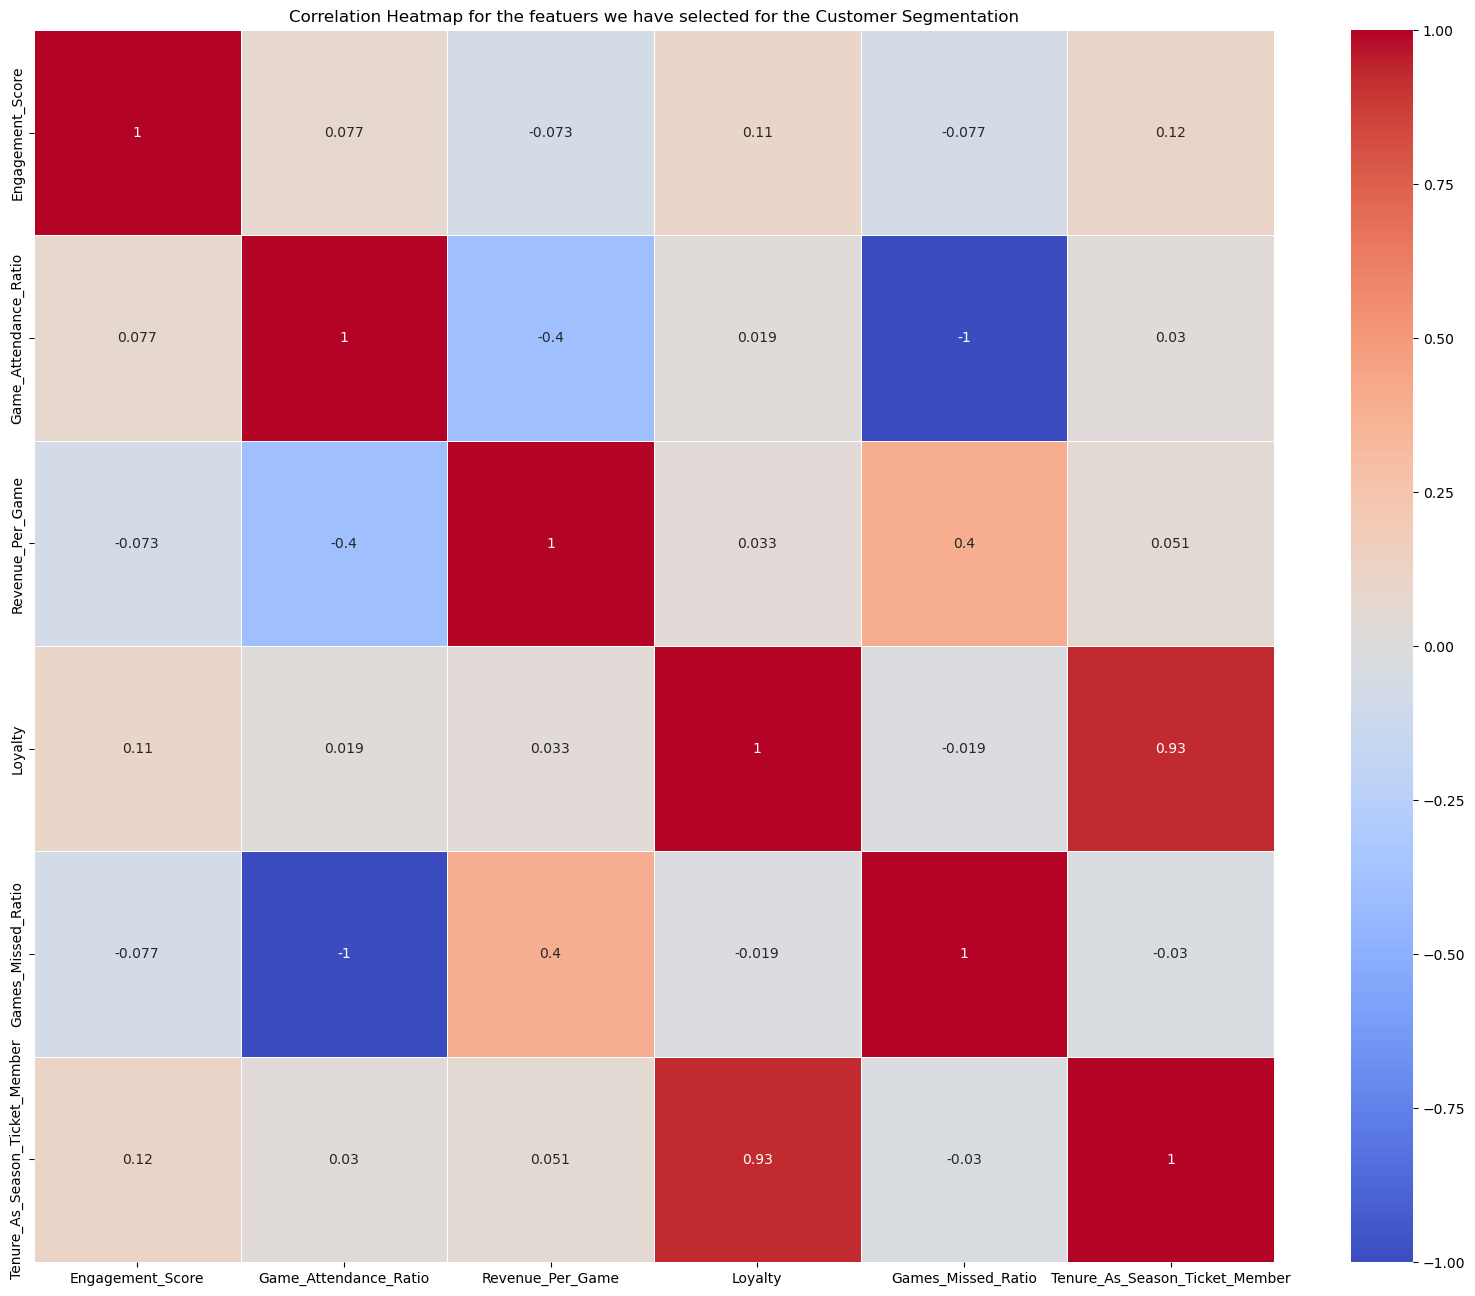

,Engagement_Score,Game_Attendance_Ratio,Revenue_Per_Game,Loyalty,Games_Missed_Ratio,Tenure_As_Season_Ticket_Member
Engagement_Score,1.000000,0.077005,-0.072624,0.106322,-0.077005,0.115955
Game_Attendance_Ratio,0.077005,1.000000,-0.395174,0.019048,-1.000000,0.030287
Revenue_Per_Game,-0.072624,-0.395174,1.000000,0.033314,0.395174,0.051388
Loyalty,0.106322,0.019048,0.033314,1.000000,-0.019048,0.925016
Games_Missed_Ratio,-0.077005,-1.000000,0.395174,-0.019048,1.000000,-0.030287
Tenure_As_Season_Ticket_Member,0.115955,0.030287,0.051388,0.925016,-0.030287,1.000000


In [39]:

X = train_df[['Engagement_Score', 'Game_Attendance_Ratio', 'Revenue_Per_Game', 
                       'Loyalty', 'Games_Missed_Ratio', 'Tenure_As_Season_Ticket_Member']]


corr_matrix = X.corr()

# Generate a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap for the featuers we have selected for the Customer Segmentation")
plt.show()

X.corr()


In [40]:
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Step 1: Refined Data Preprocessing Function
def preprocess_data_segmentation(final_dataset):
    X = final_dataset[['Engagement_Score', 'Game_Attendance_Ratio', 'Revenue_Per_Game', 
                       'Loyalty', 'Tenure_As_Season_Ticket_Member']]
    return X

# Step 2: Scaling Features (Clustering algorithms are sensitive to feature scale)
def scale_features(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

# Step 3: Automate k selection with Elbow Method and Silhouette Score
def find_optimal_clusters(X_scaled, min_clusters=3, max_clusters=10):
    inertia = []
    silhouette_scores = []
    
    # Run KMeans for a range of cluster numbers and calculate inertia and silhouette score
    for n in range(min_clusters, max_clusters + 1):
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(X_scaled)
        
        inertia.append(kmeans.inertia_)  # Sum of squared distances to the closest cluster center
        silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
    
    # Plot Elbow Method (Inertia)
    plt.figure(figsize=(10, 5))
    plt.plot(range(min_clusters, max_clusters + 1), inertia, marker='o')
    plt.title('Elbow Method for Optimal k (Inertia)')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia (Sum of Squared Distances)')
    plt.show()

    # Plot Silhouette Score
    plt.figure(figsize=(10, 5))
    plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Score for Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

    # Return the optimal number of clusters based on the "elbow" and the silhouette score
    optimal_n_clusters = np.argmax(silhouette_scores) + min_clusters
    print(f"Optimal number of clusters based on Silhouette Score: {optimal_n_clusters}")
    return optimal_n_clusters
    

# Step 4: Apply Clustering with Hyperparameter Tuning
def apply_clustering(X_scaled, algorithm='kmeans', param_grid=None):
    best_model = None
    best_score = -1
    best_params = {}
    clustering_results = []
    
    for params in ParameterGrid(param_grid):
        if algorithm == 'kmeans':
            model = KMeans(**params, random_state=42)
        elif algorithm == 'minibatch_kmeans':
            model = MiniBatchKMeans(**params, random_state=42)
        elif algorithm == 'gmm':
            model = GaussianMixture(**params, random_state=42)
        elif algorithm == 'agglomerative':
            model = AgglomerativeClustering(**params)
        else:
            raise ValueError("Unsupported algorithm")

        model.fit(X_scaled)
        labels = model.labels_ if hasattr(model, 'labels_') else model.predict(X_scaled)

        # Evaluate the clustering performance
        silhouette_avg = silhouette_score(X_scaled, labels)
        db_score = davies_bouldin_score(X_scaled, labels)

        clustering_results.append({
            'model': model,
            'params': params,
            'labels': labels,
            'silhouette_avg': silhouette_avg,
            'db_score': db_score
        })

        if silhouette_avg > best_score:
            best_model = model
            best_score = silhouette_avg
            best_params = params

    return best_model, best_params, clustering_results

# Step 5: Visualize Clusters using PCA
def visualize_clusters_pca(X_scaled, labels, algorithm, params):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(f"Clusters Visualization using {algorithm} (PCA Projection) with params {params}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar()
    plt.show()

# Step 6: Define Parameter Grids for Each Algorithm
def get_param_grids(optimal_n_clusters):
    param_grids = {
        'kmeans': {
            'n_clusters': [optimal_n_clusters],
            'init': ['k-means++', 'random'],
            'max_iter': [300, 500],
            'n_init': [10, 20]
        },
        'minibatch_kmeans': {
            'n_clusters': [optimal_n_clusters],
            'batch_size': [100, 200],
            'max_iter': [300, 500]
        },
        'gmm': {
            'n_components': [optimal_n_clusters],
            'covariance_type': ['full', 'tied', 'diag', 'spherical'],
            'max_iter': [300, 500]
        },
        'agglomerative': {
            'n_clusters': [optimal_n_clusters],
            'linkage': ['ward', 'complete', 'average', 'single']
        }
    }
    return param_grids

# Step 7: Select the Best Model from Each Algorithm
def get_best_model_from_each_algorithm(clustering_results):
    best_models = {}
    for result in clustering_results:
        algo_name = type(result['model']).__name__
        if algo_name not in best_models or result['silhouette_avg'] > best_models[algo_name]['silhouette_avg']:
            best_models[algo_name] = result
    return list(best_models.values())

# Step 8: Display Cluster Statistics and Values (with enhanced summary statistics)
def display_cluster_statistics(final_dataset, labels):
    # Define the columns used for clustering
    clustering_columns = ['Engagement_Score', 'Game_Attendance_Ratio', 'Revenue_Per_Game', 
                          'Loyalty', 'Tenure_As_Season_Ticket_Member']
    
    # Add the cluster labels to the dataset
    final_dataset['Cluster'] = labels
    
    # Group by the cluster and calculate the average values for each cluster
    cluster_stats = final_dataset.groupby('Cluster')[clustering_columns].mean()  # Average values for continuous data
    
    print("\nCluster Statistics (Mean Values for Continuous Data):")
    print(cluster_stats)

    # Show individual cluster values with enhanced summaries
    print("\nDisplaying summarized individual values for each cluster:")
    for cluster in sorted(final_dataset['Cluster'].unique()):
        print(f"\nCluster {cluster} summary:")

        # Filter the data for the current cluster
        cluster_data = final_dataset[final_dataset['Cluster'] == cluster][clustering_columns]
        
        # Calculate the mean for each column and print it
        print("\nSummary statistics for this cluster:")
        for column in clustering_columns:
            average_value = cluster_data[column].mean()
            print(f"Average {column}: {average_value:.2f}")
        
        print("\n-- Complete cluster data --\n")
        print(cluster_data)

    return cluster_stats


# Step 9: Allow User to Name Clusters
def name_clusters(cluster_stats, labels):
    cluster_names = {}
    
    print("\nSuggested Cluster Names Based on Statistics:")
    
    # Suggest names based on statistics and ask the user for final names
    for cluster_id, row in cluster_stats.iterrows():
        suggestions = []
        
        # Adjusting thresholds based on the provided statistics
        if row['Engagement_Score'] > 30:
            suggestions.append("Highly Engaged")
        elif row['Engagement_Score'] > 15:
            suggestions.append("Moderately Engaged")
        else:
            suggestions.append("Low Engagement")
        
        if row['Game_Attendance_Ratio'] > 0.75:
            suggestions.append("Frequent Attendees")
        elif row['Game_Attendance_Ratio'] > 0.5:
            suggestions.append("Occasional Attendees")
        else:
            suggestions.append("Rare Attendees")
        
        if row['Revenue_Per_Game'] > 1000:
            suggestions.append("High Spenders")
        elif row['Revenue_Per_Game'] > 500:
            suggestions.append("Moderate Spenders")
        else:
            suggestions.append("Low Spenders")
        
        if row['Loyalty'] == 1:
            suggestions.append("Loyal Customers")
        else:
            suggestions.append("New or Inconsistent Customers")

        # Output the suggested names for the cluster and allow for user input to customize
        print(f"\nCluster {cluster_id}: Suggested names -> {', '.join(suggestions)}")
        name = input(f"Enter the name for Cluster {cluster_id} (press Enter to accept suggestion or type your own): ")
        cluster_names[cluster_id] = name if name else ', '.join(suggestions)
    
    # Replace cluster labels with names
    named_labels = pd.Series(labels).map(cluster_names)
    return named_labels


# Step 10: Run Clustering Comparison with Hyperparameter Tuning and User Selection
def run_clustering_comparison(final_dataset):
    # Preprocess Data
    X = preprocess_data_segmentation(final_dataset)
    
    # Scale Features
    X_scaled = scale_features(X)
    
    # Find Optimal k
    optimal_n_clusters = find_optimal_clusters(X_scaled)
    
    # Get parameter grids with the optimal number of clusters
    param_grids = get_param_grids(optimal_n_clusters)
    
    # Store results to allow the user to choose
    clustering_results = []
    
    # List of algorithms to compare
    algorithms = ['kmeans', 'minibatch_kmeans', 'gmm', 'agglomerative']

    for algorithm in algorithms:
        print(f"\nApplying {algorithm.capitalize()} Clustering with Hyperparameter Tuning...")
        
        best_model, best_params, results = apply_clustering(X_scaled, algorithm=algorithm, param_grid=param_grids[algorithm])
        # Visualize Clusters
        labels = best_model.labels_ if hasattr(best_model, 'labels_') else best_model.predict(X_scaled)
        visualize_clusters_pca(X_scaled, labels, algorithm, best_params)
        clustering_results.extend(results)
    
    # Get the best model from each algorithm
    best_models = get_best_model_from_each_algorithm(clustering_results)
    
    # Present only the best model from each algorithm
    print("\nAvailable Clustering Models (Best from each algorithm):")
    for idx, result in enumerate(best_models):
        algo_name = type(result['model']).__name__
        print(f"{idx + 1}. {algo_name} with params {result['params']} - Silhouette Score: {result['silhouette_avg']:.4f}, Davies-Bouldin Score: {result['db_score']:.4f}")

    # User input to select the model
    user_choice = input(f"\nEnter the number of the clustering model you would like to choose (1-{len(best_models)}), or press Enter to use the suggested model: ")
    
    if user_choice.isdigit() and 1 <= int(user_choice) <= len(best_models):
        selected_model = best_models[int(user_choice) - 1]
        print(f"\nYou selected: {selected_model['model']} with params {selected_model['params']}")
    else:
        selected_model = max(best_models, key=lambda x: x['silhouette_avg'])
        print(f"\nUsing the suggested model: {selected_model['model']} with params {selected_model['params']}")

    # Visualize Clusters
    labels = selected_model['labels']
    visualize_clusters_pca(X_scaled, labels, type(selected_model['model']).__name__, selected_model['params'])

    # Display Cluster Statistics and Individual Cluster Values
    cluster_stats = display_cluster_statistics(final_dataset.copy(), labels)

    # Allow user to name clusters
    named_labels = name_clusters(cluster_stats, labels)
    
    # Save the selected model and named clusters for later use
    global customer_segmentation
    global cluster_names  # Save the cluster names
    
    customer_segmentation = selected_model['model']
    cluster_names = named_labels
    
    print("\nThe selected clustering model has been stored in 'customer_segmentation' and the cluster names have been saved in 'cluster_names'. You can now use these for further analysis.")

    return selected_model, named_labels

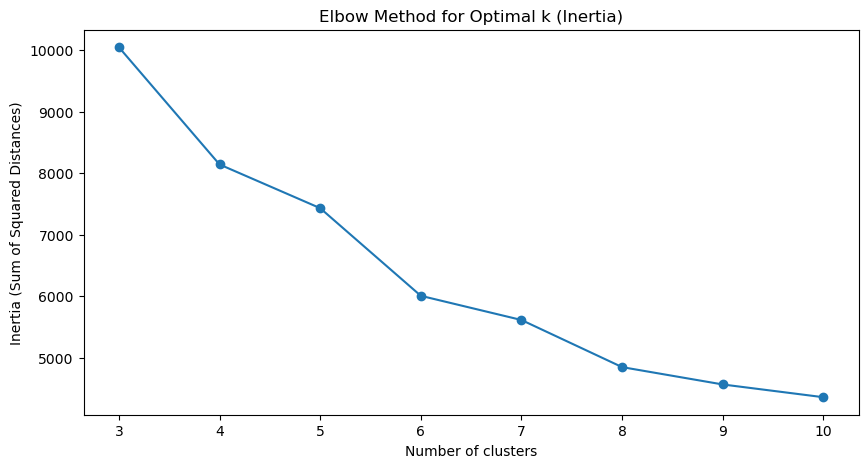

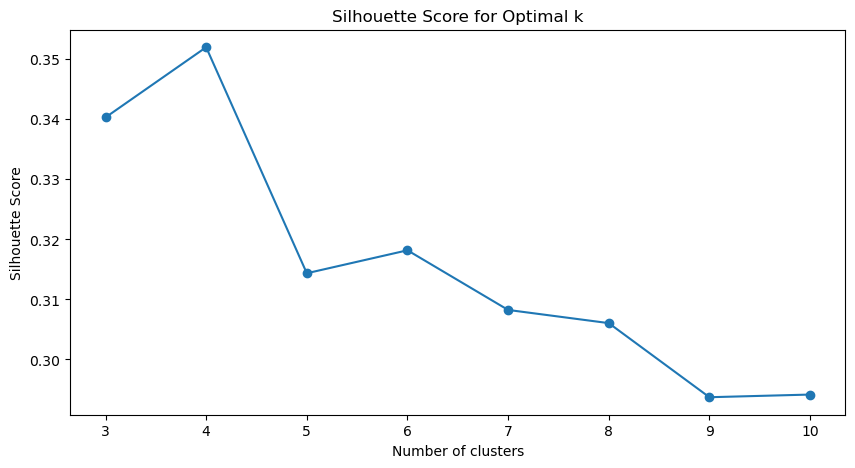

Optimal number of clusters based on Silhouette Score: 4

Applying Kmeans Clustering with Hyperparameter Tuning...


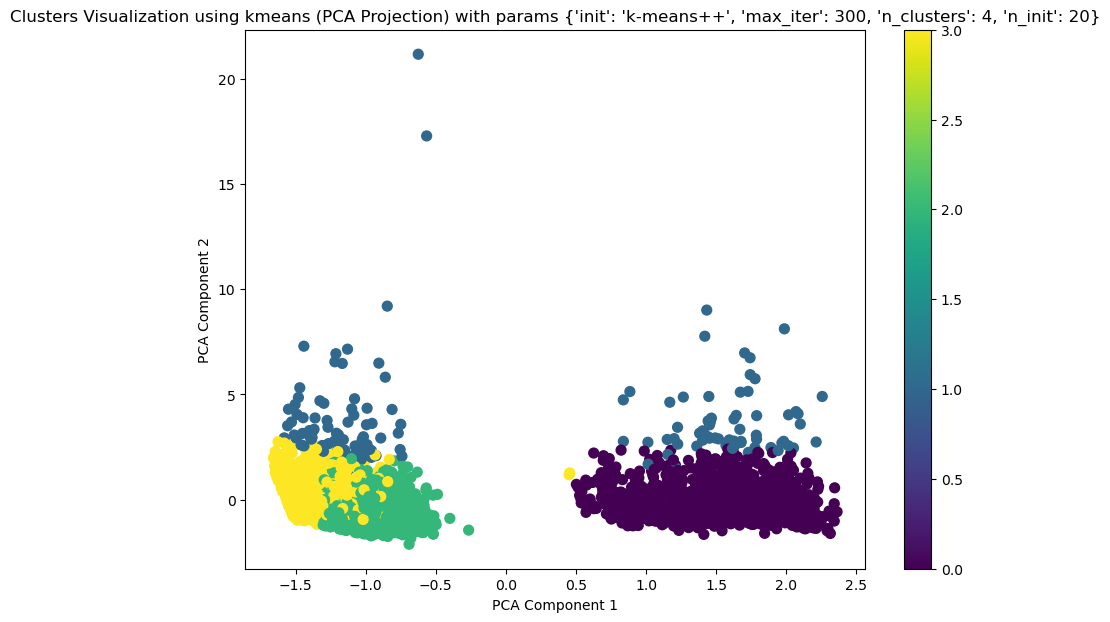


Applying Minibatch_kmeans Clustering with Hyperparameter Tuning...


D:\installers\conda\Lib\site-packages\sklearn\cluster\_kmeans.py:1972: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
D:\installers\conda\Lib\site-packages\sklearn\cluster\_kmeans.py:1972: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
D:\installers\conda\Lib\site-packages\sklearn\cluster\_kmeans.py:1972: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
D:\installers\conda\Li

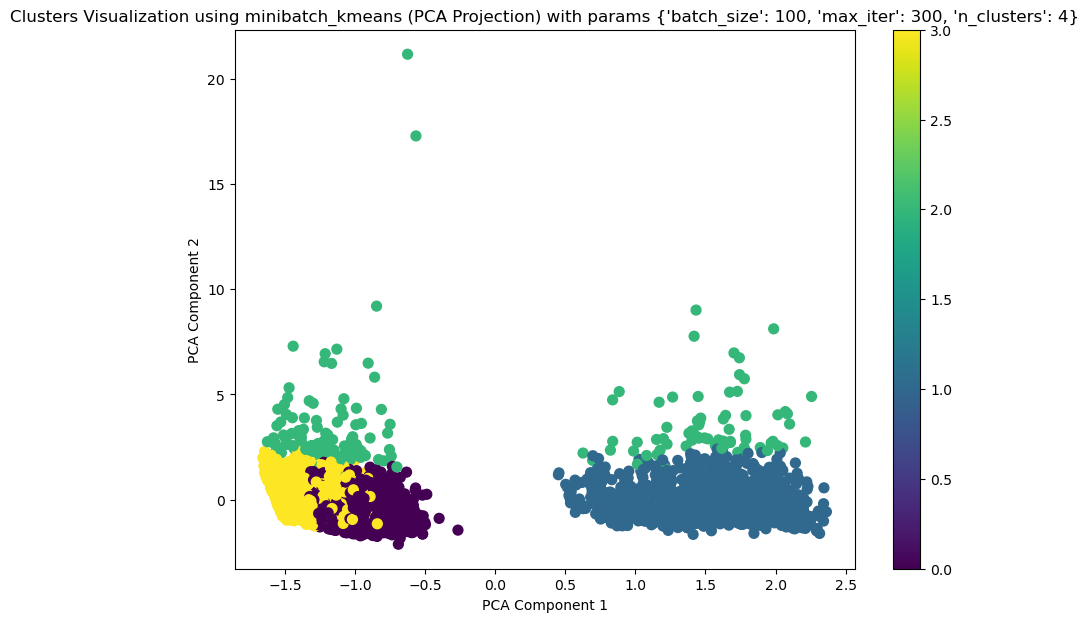


Applying Gmm Clustering with Hyperparameter Tuning...


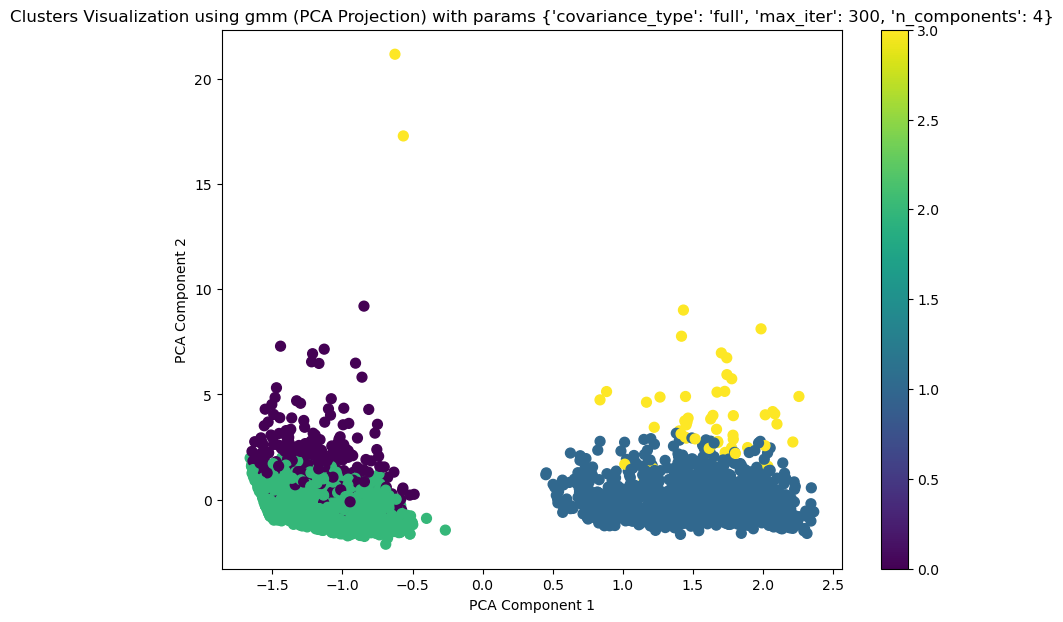


Applying Agglomerative Clustering with Hyperparameter Tuning...


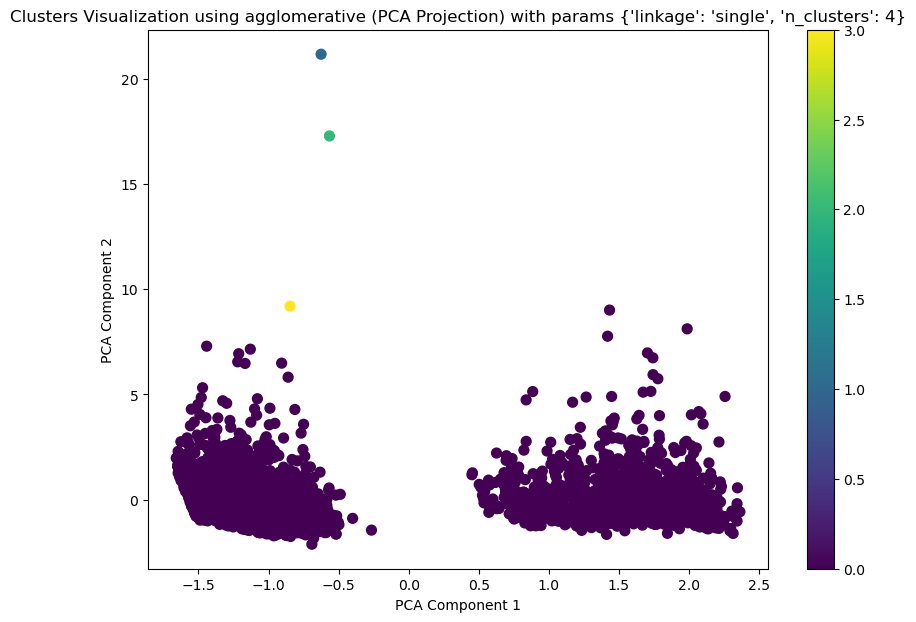


Available Clustering Models (Best from each algorithm):
1. KMeans with params {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 4, 'n_init': 20} - Silhouette Score: 0.3524, Davies-Bouldin Score: 1.1031
2. MiniBatchKMeans with params {'batch_size': 100, 'max_iter': 300, 'n_clusters': 4} - Silhouette Score: 0.3483, Davies-Bouldin Score: 1.1124
3. GaussianMixture with params {'covariance_type': 'full', 'max_iter': 300, 'n_components': 4} - Silhouette Score: 0.3859, Davies-Bouldin Score: 1.3139
4. AgglomerativeClustering with params {'linkage': 'single', 'n_clusters': 4} - Silhouette Score: 0.7493, Davies-Bouldin Score: 0.1322



Enter the number of the clustering model you would like to choose (1-4), or press Enter to use the suggested model:  3



You selected: GaussianMixture(max_iter=300, n_components=4, random_state=42) with params {'covariance_type': 'full', 'max_iter': 300, 'n_components': 4}


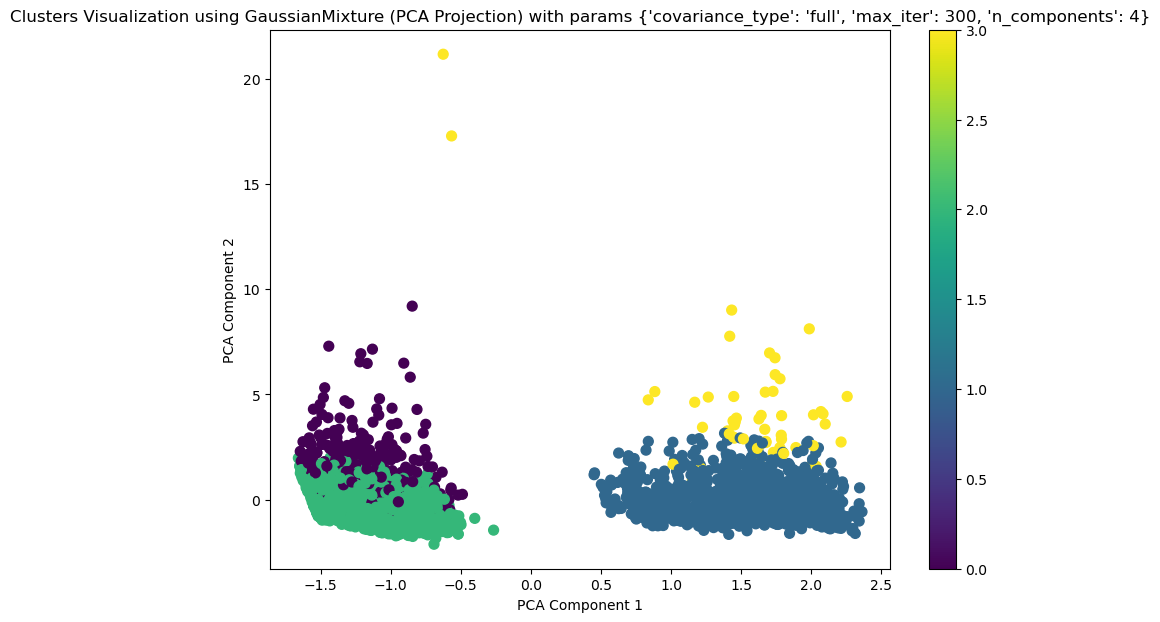


Cluster Statistics (Mean Values for Continuous Data):
         Engagement_Score  Game_Attendance_Ratio  Revenue_Per_Game   Loyalty  \
Cluster                                                                        
0               25.427562               0.409478        408.602365  0.000000   
1               31.999354               0.705047         99.829914  1.000000   
2               27.983096               0.721233         61.599181  0.000000   
3               19.277778               0.315904       1046.076525  0.962963   

         Tenure_As_Season_Ticket_Member  
Cluster                                  
0                              1.664311  
1                              7.398967  
2                              1.623877  
3                              7.666667  

Displaying summarized individual values for each cluster:

Cluster 0 summary:

Summary statistics for this cluster:
Average Engagement_Score: 25.43
Average Game_Attendance_Ratio: 0.41
Average Revenue_Per_Game: 4

Enter the name for Cluster 0 (press Enter to accept suggestion or type your own):  



Cluster 1: Suggested names -> Highly Engaged, Occasional Attendees, Low Spenders, Loyal Customers


Enter the name for Cluster 1 (press Enter to accept suggestion or type your own):  



Cluster 2: Suggested names -> Moderately Engaged, Occasional Attendees, Low Spenders, New or Inconsistent Customers


Enter the name for Cluster 2 (press Enter to accept suggestion or type your own):  



Cluster 3: Suggested names -> Moderately Engaged, Rare Attendees, High Spenders, New or Inconsistent Customers


Enter the name for Cluster 3 (press Enter to accept suggestion or type your own):  



The selected clustering model has been stored in 'customer_segmentation' and the cluster names have been saved in 'cluster_names'. You can now use these for further analysis.


({'model': GaussianMixture(max_iter=300, n_components=4, random_state=42),
  'params': {'covariance_type': 'full', 'max_iter': 300, 'n_components': 4},
  'labels': array([2, 2, 2, ..., 2, 2, 2], dtype=int64),
  'silhouette_avg': 0.38586564268308865,
  'db_score': 1.3139449831540273},
 0       Moderately Engaged, Occasional Attendees, Low ...
 1       Moderately Engaged, Occasional Attendees, Low ...
 2       Moderately Engaged, Occasional Attendees, Low ...
 3       Moderately Engaged, Occasional Attendees, Low ...
 4       Highly Engaged, Occasional Attendees, Low Spen...
                               ...                        
 3774    Moderately Engaged, Occasional Attendees, Low ...
 3775    Moderately Engaged, Occasional Attendees, Low ...
 3776    Moderately Engaged, Occasional Attendees, Low ...
 3777    Moderately Engaged, Occasional Attendees, Low ...
 3778    Moderately Engaged, Occasional Attendees, Low ...
 Length: 3779, dtype: object)

In [41]:
run_clustering_comparison(df)


# Lifetime Value Prediction 

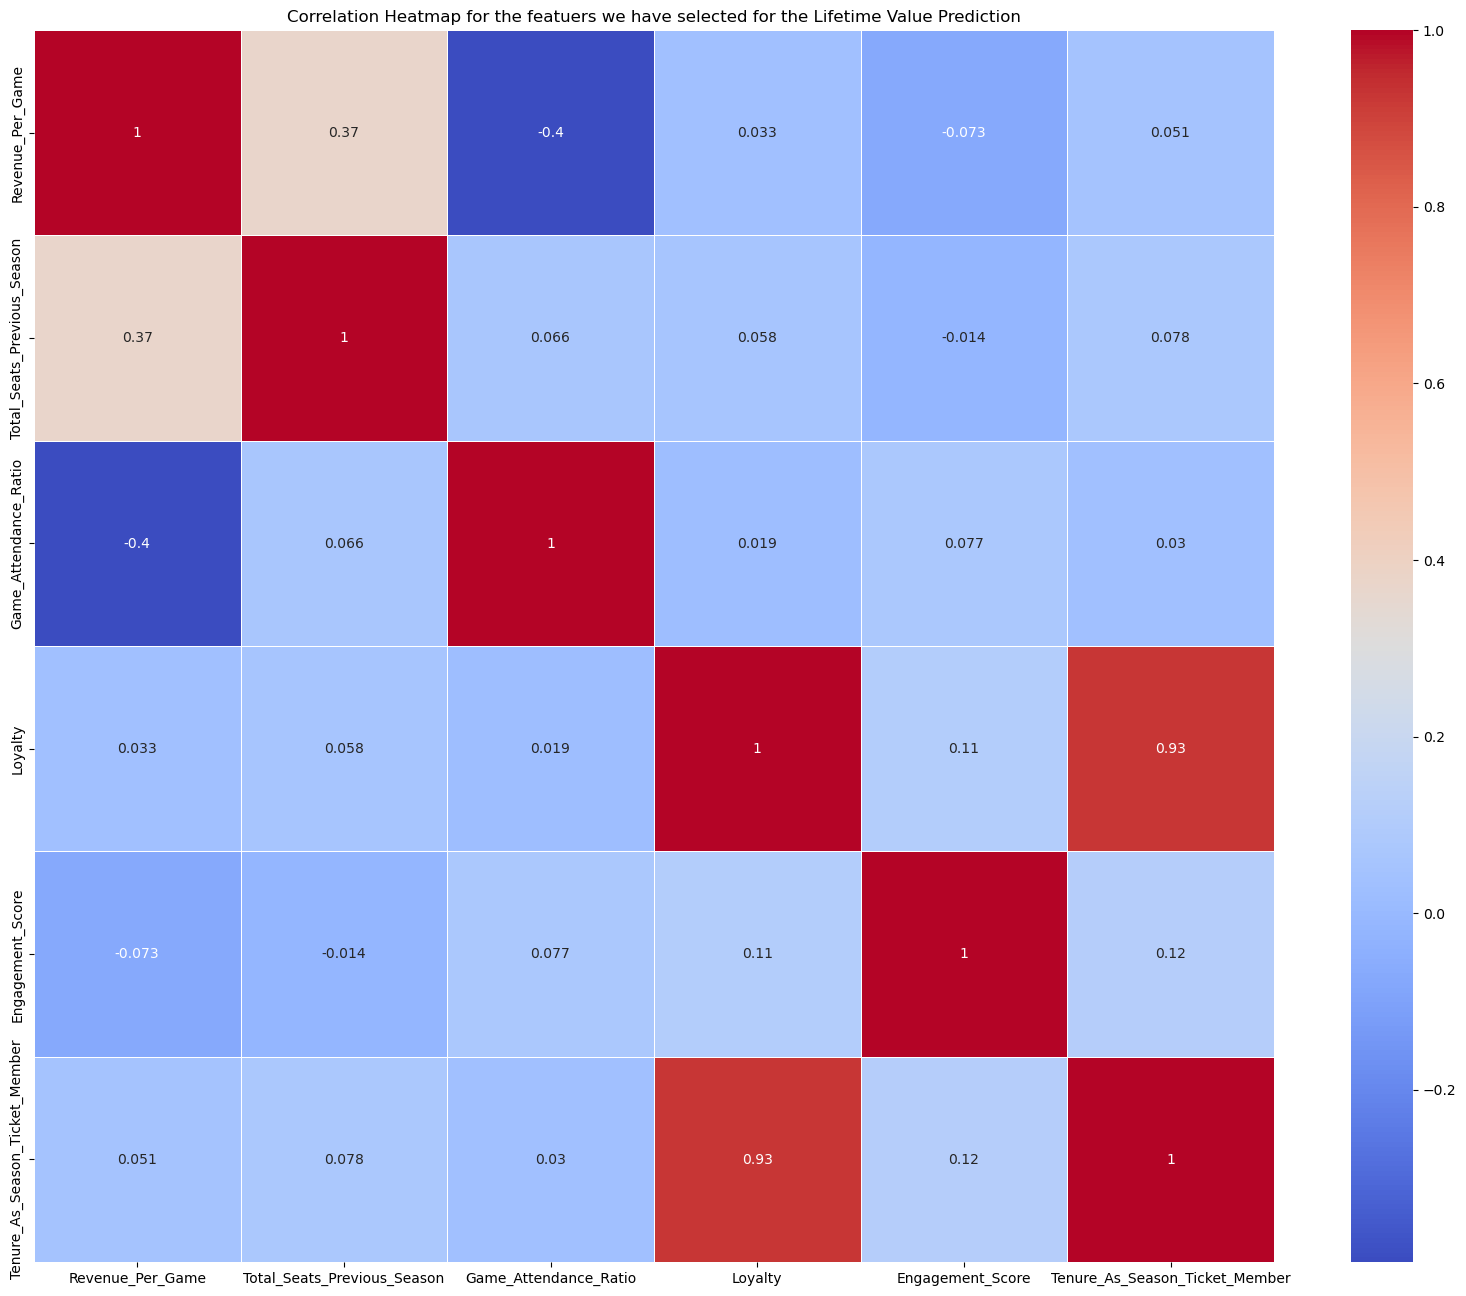

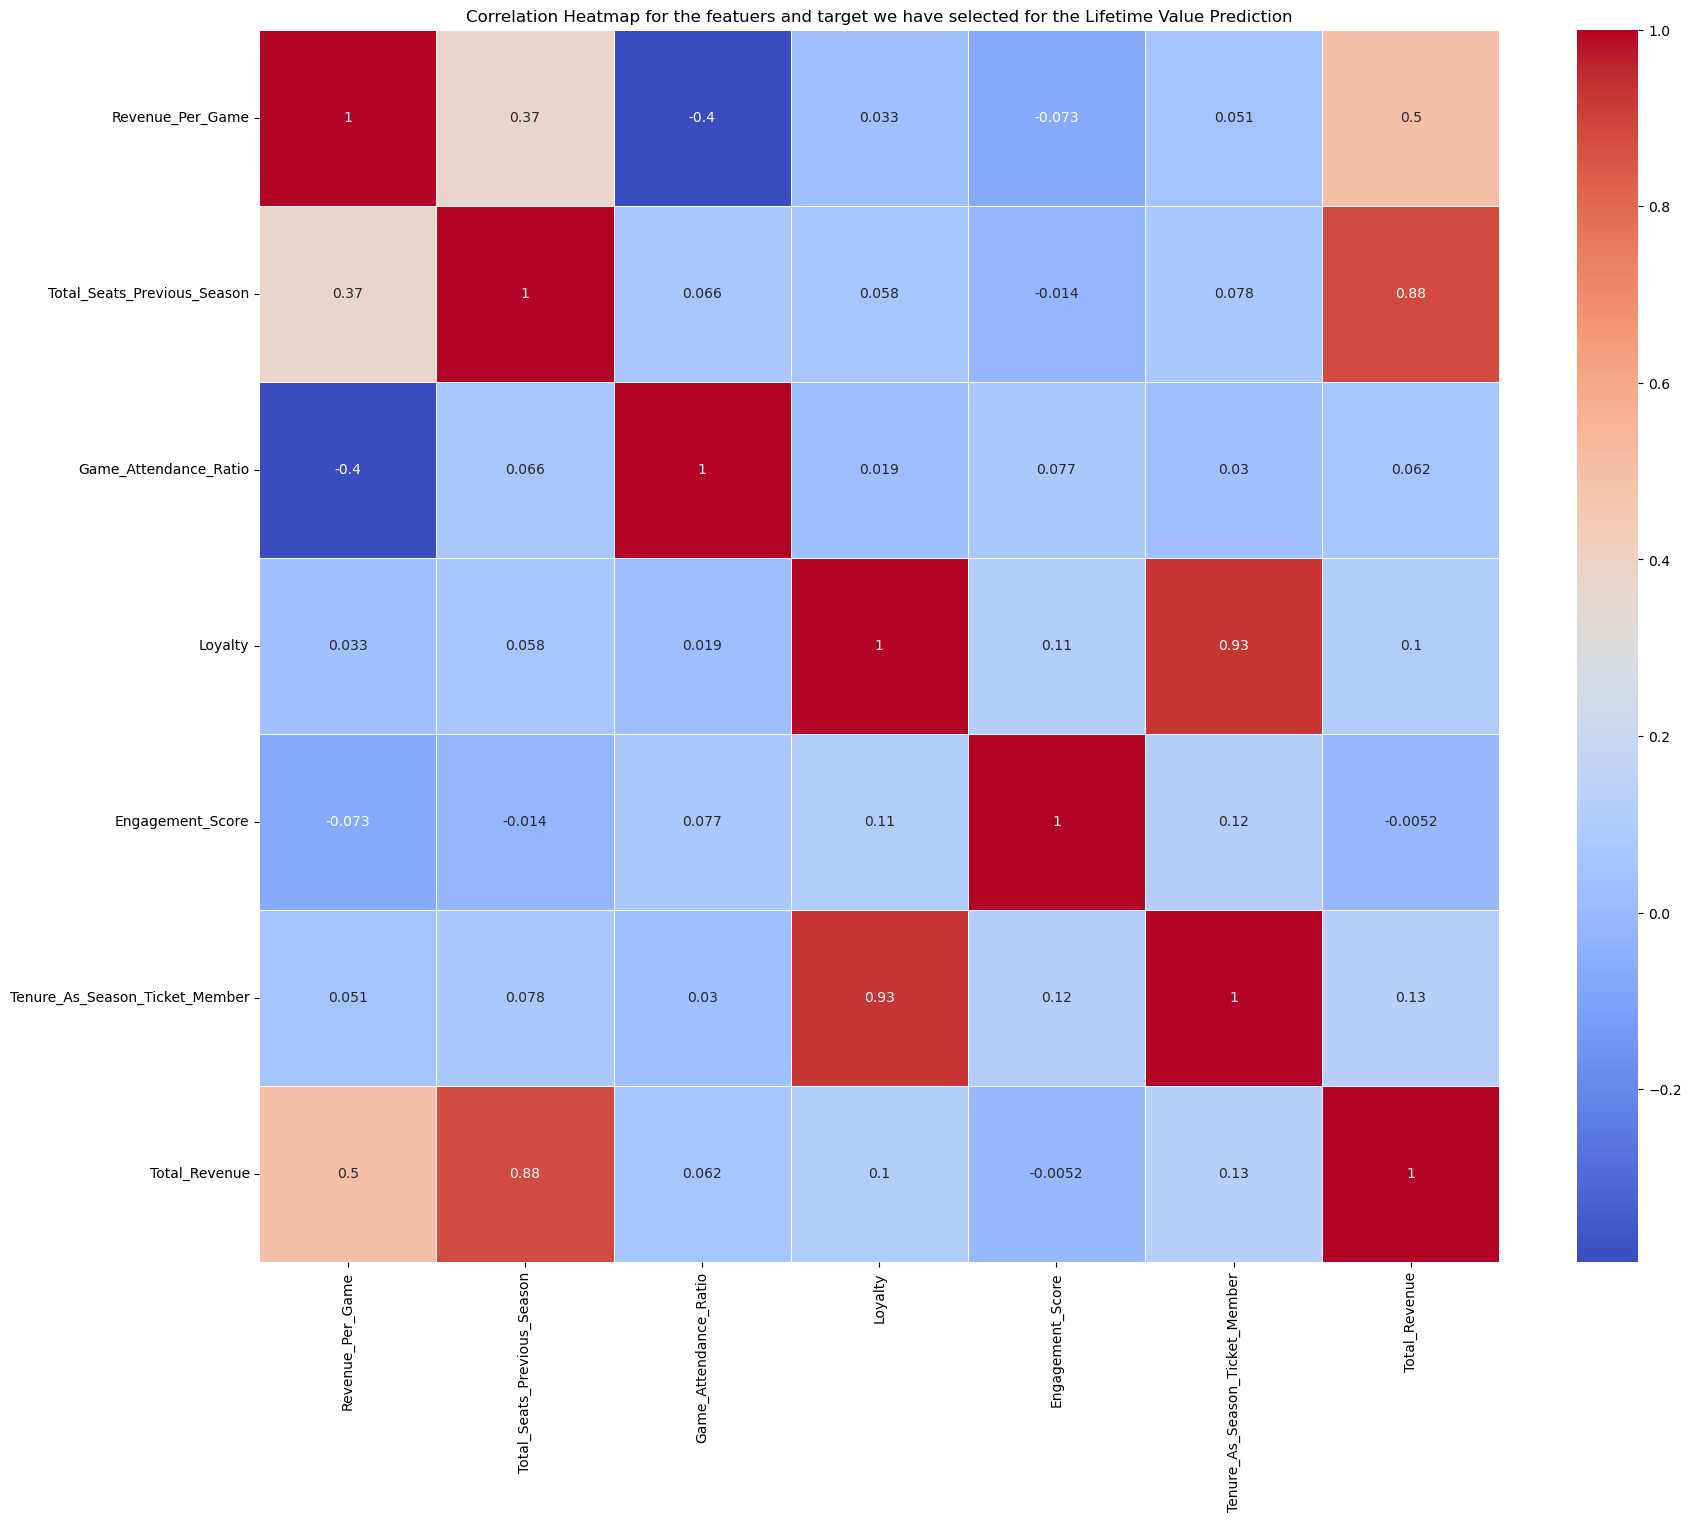

In [42]:
df1 = train_df[['Revenue_Per_Game', 
                       'Total_Seats_Previous_Season', 
                       'Game_Attendance_Ratio',
                       'Loyalty',
                       'Engagement_Score',
                       'Tenure_As_Season_Ticket_Member','Total_Revenue']]
X = train_df[['Revenue_Per_Game', 
                       'Total_Seats_Previous_Season', 
                       'Game_Attendance_Ratio',
                       'Loyalty',
                       'Engagement_Score',
                       'Tenure_As_Season_Ticket_Member']]

corr_matrix1 = df1.corr()
corr_matrix = X.corr()

# Generate a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap for the featuers we have selected for the Lifetime Value Prediction")
plt.show()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix1, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap for the featuers and target we have selected for the Lifetime Value Prediction")
plt.show()


In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
import numpy as np

# Step 1: Data Preprocessing for Lifetime Value Prediction
def preprocess_data_lifetime_value(df):
    X = df[['Revenue_Per_Game', 
            'Total_Seats_Previous_Season', 
            'Game_Attendance_Ratio',
            'Engagement_Score',
            'Tenure_As_Season_Ticket_Member']]
    y = df['Total_Revenue']
    return X, y

# Step 2: Build Regression Pipeline with Conditional Scaling
def build_regression_pipeline(model, scaler=True):
    steps = []
    # Skip scaling for tree-based models (RandomForest, XGBoost)
    if scaler and not isinstance(model, (RandomForestRegressor, XGBRegressor)):
        steps.append(('scaler', StandardScaler()))
    steps.append(('regressor', model))
    return Pipeline(steps)

# Step 3: Hyperparameter Tuning (RandomizedSearchCV and GridSearchCV)
def tune_model(model, param_grid, X_train, y_train, use_random_search=False, cv=5):
    if use_random_search:
        search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=20, 
                                    cv=cv, scoring='r2', n_jobs=4, verbose=2, random_state=42)
    else:
        search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=2)
    
    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_

# Step 4: Evaluate Model Performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    print(f"R-squared: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    
    return r2, mae, mse

# Step 5: Cross-Validation for Model Performance
def cross_validate_model(model, X, y, cv=5):
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
    return r2_scores.mean(), r2_scores.std()

# Step 6: Define Regressor Algorithms and Parameter Grids
regression_algorithms = {
    "Linear Regression": build_regression_pipeline(LinearRegression()),
    "Random Forest": build_regression_pipeline(RandomForestRegressor(random_state=42), scaler=False),
    "XGBoost": build_regression_pipeline(XGBRegressor(random_state=42, tree_method='hist', eval_metric='rmse'), scaler=False)
}

param_grids = {
    "Linear Regression": {
        # No hyperparameters to tune for basic Linear Regression
    },
    "Random Forest": {
        'regressor__n_estimators': [100, 200, 500],
        'regressor__max_depth': [5, 10, 20],
        'regressor__min_samples_split': [2, 5, 10]
    },
    "XGBoost": {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__max_depth': [3, 5, 7],
        'regressor__subsample': [0.5, 0.7, 1.0],
        'regressor__colsample_bytree': [0.3, 0.7, 1.0]
    }
}

# Step 7: Run Lifetime Value Prediction Model with Pre-split Data
def run_lifetime_value_prediction_model(train_df, test_df):
    # Preprocess Data
    X_train, y_train = preprocess_data_lifetime_value(train_df)
    X_test, y_test = preprocess_data_lifetime_value(test_df)
    
    best_models = []
    
    # Tune and Evaluate Each Regressor Model
    for idx, (name, model) in enumerate(regression_algorithms.items(), 1):
        print(f"\nTuning {name}...")
        
        # For XGBoost, we use RandomizedSearchCV to reduce computational load
        if name == "XGBoost":
            best_model, best_param = tune_model(model, param_grids[name], X_train, y_train, use_random_search=True)
        else:
            best_model, best_param = tune_model(model, param_grids[name], X_train, y_train)
        
        print(f"Best parameters for {name}: {best_param}")
        
        # Cross-validating the model
        cv_mean, cv_std = cross_validate_model(best_model, X_train, y_train)
        print(f"Cross-validated R-squared for {name}: {cv_mean:.4f} (+/- {cv_std:.4f})")
        
        # Evaluate on Test Set
        r2, mae, mse = evaluate_model(best_model, X_test, y_test)
        
        best_models.append({
            'id': idx,
            'name': name,
            'model': best_model,
            'r2': r2,
            'mae': mae,
            'mse': mse,
            'cv_mean': cv_mean,
            'cv_std': cv_std
        })
    
    # Display the models and their performances for user selection
    print("\nAvailable Models:")
    for idx, model_info in enumerate(best_models, 1):
        print(f"{idx}. {model_info['name']}:")
        print(f"   R-squared: {model_info['r2']:.4f}")
        print(f"   Mean Absolute Error (MAE): {model_info['mae']:.4f}")
        print(f"   Mean Squared Error (MSE): {model_info['mse']:.4f}")
        print(f"   Cross-validated R-squared: {model_info['cv_mean']:.4f} (+/- {model_info['cv_std']:.4f})")
    
    # User input to select the model
    while True:
        try:
            selection = int(input(f"\nSelect the model by number (1-{len(best_models)}): "))
            if 1 <= selection <= len(best_models):
                selected_model = best_models[selection - 1]['model']
                print(f"\nYou have selected: {best_models[selection - 1]['name']} and the model is saved as 'lifetime_value_prediction'")
                break
            else:
                print(f"Invalid input. Please select a number between 1 and {len(best_models)}.")
        except ValueError:
            print("Invalid input. Please enter a number.")
    
    return selected_model



In [44]:
lifetime_value_prediction = run_lifetime_value_prediction_model(train_df, test_df)



Tuning Linear Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for Linear Regression: {}
Cross-validated R-squared for Linear Regression: 0.7909 (+/- 0.0739)
R-squared: 0.8796
Mean Absolute Error (MAE): 271.5297
Mean Squared Error (MSE): 246221.2853

Tuning Random Forest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for Random Forest: {'regressor__max_depth': 20, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Cross-validated R-squared for Random Forest: 0.9583 (+/- 0.0122)
R-squared: 0.9660
Mean Absolute Error (MAE): 62.0676
Mean Squared Error (MSE): 69476.0268

Tuning XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for XGBoost: {'regressor__subsample': 0.7, 'regressor__n_estimators': 300, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.2, 'regressor__colsample_bytree': 1.0}
Cross-validated R-squared for XGBoost: 0.9782 (+/- 0.0068)
R-squared


Select the model by number (1-3):  3



You have selected: XGBoost and the model is saved as 'lifetime_value_prediction'


In [45]:
print(churn_prediction)
print(customer_segmentation)
print(lifetime_value_prediction)


Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimator

In [46]:
import joblib

# Assume `model` is the variable where your trained model is stored
joblib.dump(churn_prediction, 'churn_prediction.pkl')
joblib.dump(customer_segmentation, 'customer_segmentation.pkl')
joblib.dump(lifetime_value_prediction, 'lifetime_value_prediction.pkl')
joblib.dump(cluster_names, 'cluster_labels_mapping.pkl')
print('Saved 3 models and 1 cluster name files as .pkl at the default location......')
# To load the saved model later:
#loaded_model = joblib.load('model_filename.pkl')


Saved 3 models and 1 cluster name files as .pkl at the default location......
